## Please Read

The following notebook is an adaptation of a popular [notebook](https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners) by Jeremy Howard discussed in fast.ai's [Practical Deep Learning for Coders – Lesson 4](https://course.fast.ai/Lessons/lesson4.html).

In order for this notebook to run on Kaggle in a reasonable amount of time (~ 2 h) the model will be trained on only 2 % of the training data sampled randomly. Please note that this notebook serves only as a training demo, since for best results the model needs to be fine-tuned on all training data. For context: Fine-tuning the model for 5 epochs on an A10 GPU using a batch size of 256 and a train-valid-split of 80/20 took about 12 hours. For predictions submitted to the Open Problems – Single-Cell Perturbation competition the model was fine-tuned for 20–25 epochs.

## Imports and Random Seed

In [1]:
import time
t0start = time.time()
from fastai.collab import *
from fastai.tabular.all import *
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
random_seed = 42

In [3]:
from transformers import set_seed
set_seed(random_seed)

## Prepare Train Set

Here I read the training data and melt it to yield a ```DataFrame``` with three categorical features (```cell_type```, ```sm_name```, and ```gene```) and one target (```value```).

In [4]:
%%time
fn = '/kaggle/input/open-problems-single-cell-perturbations/de_train.parquet'
df_de_train = pd.read_parquet(fn)# , index_col = 0)
train_df = df_de_train.drop(columns=['sm_lincs_id', 'SMILES', 'control'])
trdf = train_df.melt(id_vars=['cell_type', 'sm_name'], value_vars=train_df.iloc[:,2:].columns, var_name='gene', value_name='value')

CPU times: user 3.6 s, sys: 800 ms, total: 4.4 s
Wall time: 4.65 s


The next line samples 2 % of the training data to demonstrate model training in a reasonable time frame:

In [5]:
trdf = trdf.sample(frac=0.02).reset_index(drop=true)

## Prepare Test Set

Similar procedure for the test set.

In [6]:
fn = '/kaggle/input/open-problems-single-cell-perturbations/id_map.csv'
df_id_map = pd.read_csv(fn)
fn = '/kaggle/input/open-problems-single-cell-perturbations/sample_submission.csv'
df = pd.read_csv(fn, index_col = 0)

cols_to_add = df_de_train.iloc[:,5:].columns
cols_to_add

df_zeros = pd.DataFrame(0.0, columns=cols_to_add, index=df_id_map.index)
df_zeros

df_id_map_preds = pd.concat([df_id_map, df_zeros], axis=1)
tsdf = df_id_map_preds.melt(id_vars=['cell_type', 'sm_name'], value_vars=df_id_map_preds.iloc[:,3:].columns, var_name='gene', value_name='value')

## Inspect Train and Test Set

In [7]:
trdf

,cell_type,sm_name,gene,value
0,NK cells,Sunitinib,LINC00824,0.243416
1,NK cells,Lamivudine,CCDC61,-0.104237
2,T cells CD4+,Ceritinib,PSMD6,0.276361
3,NK cells,Isoniazid,KIF3B,-0.135494
4,T cells CD4+,GSK-1070916,TSGA13,-0.286420
...,...,...,...,...
223626,T cells CD8+,TR-14035,C1ORF123,-0.535818
223627,T regulatory cells,Phenylbutazone,ZSWIM9,-0.476339
223628,B cells,Linagliptin,ZNF546,0.138497
223629,T cells CD8+,CEP-37440,SPDYE1,-0.805262


In [8]:
tsdf

,cell_type,sm_name,gene,value
0,B cells,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6-yl)pyrimidin-2-amine,A1BG,0.0
1,B cells,ABT-199 (GDC-0199),A1BG,0.0
2,B cells,ABT737,A1BG,0.0
3,B cells,AMD-070 (hydrochloride),A1BG,0.0
4,B cells,AT 7867,A1BG,0.0
...,...,...,...,...
4643800,Myeloid cells,Vandetanib,ZZEF1,0.0
4643801,Myeloid cells,Vanoxerine,ZZEF1,0.0
4643802,Myeloid cells,Vardenafil,ZZEF1,0.0
4643803,Myeloid cells,Vorinostat,ZZEF1,0.0


## Prepare Transformer Input

In [9]:
trdf['input'] = 'CELL TYPE: ' + trdf.cell_type + '; TREATMENT: ' + trdf.sm_name + '; GENE: ' + trdf.gene
trdf.input.head()

0       CELL TYPE: NK cells; TREATMENT: Sunitinib; GENE: LINC00824
1         CELL TYPE: NK cells; TREATMENT: Lamivudine; GENE: CCDC61
2       CELL TYPE: T cells CD4+; TREATMENT: Ceritinib; GENE: PSMD6
3           CELL TYPE: NK cells; TREATMENT: Isoniazid; GENE: KIF3B
4    CELL TYPE: T cells CD4+; TREATMENT: GSK-1070916; GENE: TSGA13
Name: input, dtype: object

In [10]:
tsdf['input'] = 'CELL TYPE: ' + tsdf.cell_type + '; TREATMENT: ' + tsdf.sm_name + '; GENE: ' + tsdf.gene
tsdf.input.head()

0    CELL TYPE: B cells; TREATMENT: 5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6-yl)pyrimidin-2-amine; GENE: A1BG
1                                                      CELL TYPE: B cells; TREATMENT: ABT-199 (GDC-0199); GENE: A1BG
2                                                                  CELL TYPE: B cells; TREATMENT: ABT737; GENE: A1BG
3                                                 CELL TYPE: B cells; TREATMENT: AMD-070 (hydrochloride); GENE: A1BG
4                                                                 CELL TYPE: B cells; TREATMENT: AT 7867; GENE: A1BG
Name: input, dtype: object

In [11]:
from datasets import Dataset, DatasetDict
trds = Dataset.from_pandas(trdf)
trds

Dataset({
    features: ['cell_type', 'sm_name', 'gene', 'value', 'input'],
    num_rows: 223631
})

In [12]:
tsds = Dataset.from_pandas(tsdf)
tsds

Dataset({
    features: ['cell_type', 'sm_name', 'gene', 'value', 'input'],
    num_rows: 4643805
})

## Prepare Model

### Tokenize

In [13]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model_nm = 'microsoft/deberta-v3-small'
tokz = AutoTokenizer.from_pretrained(model_nm)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

In [14]:
L(tokz.tokenize(trds['input'][0]))

(#17) ['▁CELL','▁TYPE',':','▁NK','▁cells',';','▁TREATMENT',':','▁Sun','itinib'...]

In [15]:
def tok_func(x): return tokz(x["input"])

tok_trds = trds.map(tok_func, batched = True)
tok_tsds = tsds.map(tok_func, batched = True)

  0%|          | 0/224 [00:00<?, ?ba/s]

  0%|          | 0/4644 [00:00<?, ?ba/s]

In [16]:
tok_trds.save_to_disk('tokenized-train-dataset')
tok_tsds.save_to_disk('tokenized-test-dataset')

In [17]:
print('Started tokenization...')
from datasets import load_from_disk
tok_trds = load_from_disk('tokenized-train-dataset')
tok_tsds = load_from_disk('tokenized-test-dataset')

Started tokenization...


In [18]:
tok_trds[0]['input'], L(tok_trds[0]['input_ids'])

('CELL TYPE: NK cells; TREATMENT: Sunitinib; GENE: LINC00824',
 (#19) [1,72954,45168,294,27507,1891,346,91354,294,3041...])

In [19]:
tok_tsds[0]['input'], L(tok_tsds[0]['input_ids'])

('CELL TYPE: B cells; TREATMENT: 5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6-yl)pyrimidin-2-amine; GENE: A1BG',
 (#49) [1,72954,45168,294,736,1891,346,91354,294,456...])

In [20]:
for i in tok_tsds[0]['input_ids']:
    print(tokz.decode(i))

[CLS]
CELL
TYPE
:
B
cells
;
TREATMENT
:
5
-
(
9
-
I
so
propyl
-
8
-
methyl
-
2
-
morph
olino
-
9
H
-
pur
in
-
6
-
yl
)
pyrimidin
-
2
-
amine
;
GENE
:
A
1
BG
[SEP]


In [21]:
tok_trds = tok_trds.rename_columns({"value":"labels"})
tok_trds

Dataset({
    features: ['cell_type', 'sm_name', 'gene', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 223631
})

### Split Train Data

In [22]:
dds = tok_trds.train_test_split(0.20, seed=random_seed)
dds

DatasetDict({
    train: Dataset({
        features: ['cell_type', 'sm_name', 'gene', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 178904
    })
    test: Dataset({
        features: ['cell_type', 'sm_name', 'gene', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 44727
    })
})

### Define Model

In [23]:
bs = 64
epochs = 5
lr = 8e-5

In [24]:
steps = len(dds['train']) // bs
steps

2795

In [25]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments('outputs', save_steps=steps, learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none', seed=random_seed) # resume_from_checkpoint="/kaggle/working/20231005/outputs/checkpoint-104826"

In [26]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1) # for checkpoint use e.g. "/kaggle/working/20231005/outputs/checkpoint-104826" instead of model_nm
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz)

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.weight', 'classifier.bias', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training

In [27]:
print('Started training...')
trainer.train()

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Started training...


Epoch,Training Loss,Validation Loss
1,4.658900,4.424396
2,3.747700,4.076654
3,3.962600,3.998851
4,2.957700,3.878659
5,2.997100,3.800170


TrainOutput(global_step=13980, training_loss=3.7786596906713834, metrics={'train_runtime': 2978.1551, 'train_samples_per_second': 300.36, 'train_steps_per_second': 4.694, 'total_flos': 8643392775930000.0, 'train_loss': 3.7786596906713834, 'epoch': 5.0})

In [28]:
model_string = 'deberta-v3-small_sparse_prompt_5eps42'
trainer.save_model(f'./{model_string}/')

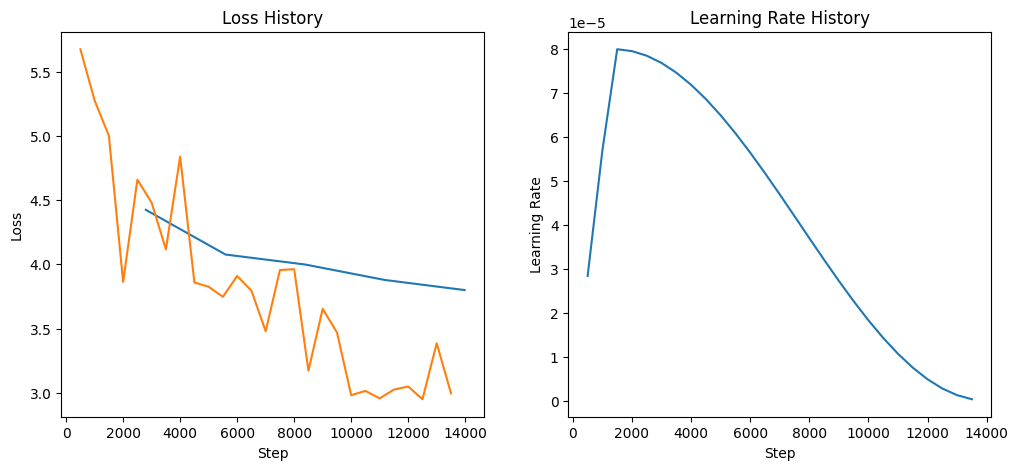

In [29]:
valid_loss_history = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]
valid_step_history = [log['step'] for log in trainer.state.log_history if 'eval_loss' in log]
train_loss_history = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
train_step_history = [log['step'] for log in trainer.state.log_history if 'loss' in log]
lrate_history = [log['learning_rate'] for log in trainer.state.log_history if 'loss' in log]
epoch_history = [log['epoch'] for log in trainer.state.log_history if 'eval_loss' in log]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(valid_step_history, valid_loss_history)
ax1.plot(train_step_history, train_loss_history)
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss')
ax1.set_title('Loss History')

ax2.plot(train_step_history, lrate_history)
ax2.set_xlabel('Step')
ax2.set_ylabel('Learning Rate')
ax2.set_title('Learning Rate History')

plt.savefig(f'{model_string}_training.pdf', format='pdf')
plt.tight_layout
plt.show()

In [30]:
with open(f'{model_string}_training_history.txt', 'w') as file:
    file.write(str(trainer.state.log_history))

## Predict

In [31]:
print('Started inference...')
preds = trainer.predict(tok_tsds).predictions.astype(float)
preds

Started inference...


array([[ 0.29223633],
       [ 0.08538818],
       [ 0.38500977],
       ...,
       [-0.05145264],
       [ 3.3671875 ],
       [ 0.13562012]])

In [32]:
preds.max(), preds.min()

(21.78125, -1.9404296875)

In [33]:
preds_rounded = np.round_(preds, 4)
preds_rounded

array([[ 0.2922],
       [ 0.0854],
       [ 0.385 ],
       ...,
       [-0.0515],
       [ 3.3672],
       [ 0.1356]])

In the last step I reshape the predictions back into a 255 x 18211 tensor for submission:

In [34]:
to_submit = preds_rounded.reshape(18211, -1).T

In [35]:
submit = pd.DataFrame(to_submit, columns=df_de_train.iloc[:,5:].columns)
submit.index.name = 'id'
submit

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
id,,,,,,,,,,,,,,,,,,,,,
0,0.2922,0.4385,0.2299,0.4395,0.4011,0.3657,0.3103,0.4307,0.0262,0.4863,...,0.1892,0.2456,0.2668,0.3098,0.3162,0.3562,0.3997,0.2656,0.2471,0.4165
1,0.0854,0.1747,0.0409,0.1469,0.1151,0.1255,0.0752,0.1273,-0.0136,0.1840,...,0.0059,0.0612,0.0669,0.0830,0.0849,0.0917,0.0984,0.0688,0.0604,0.1458
2,0.3850,0.6890,0.1698,0.6162,0.5776,0.3643,0.1515,0.4375,-0.0202,0.6021,...,0.0086,0.2030,0.2478,0.2869,0.2739,0.3357,0.3792,0.1776,0.2083,0.4414
3,0.0331,0.1292,-0.0042,0.1091,0.0540,0.0824,0.0234,0.0779,-0.0175,0.1343,...,-0.0219,0.0147,0.0233,0.0371,0.0406,0.0326,0.0431,0.0269,0.0271,0.0830
4,0.0342,0.1246,0.0004,0.1099,0.0857,0.1204,-0.0170,0.1045,-0.0598,0.1357,...,-0.0468,0.0461,0.0334,0.0506,0.0555,0.0526,0.0767,0.0457,0.0184,0.1322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,-0.1447,-0.0931,-0.2517,-0.1245,-0.1283,0.0005,-0.1587,-0.0127,-0.4153,-0.0107,...,-0.1782,-0.0953,-0.1113,-0.0707,-0.0752,-0.0645,-0.0313,-0.0810,-0.0898,-0.0236
251,0.2183,0.6333,0.1174,0.5850,0.4697,0.4583,0.0048,0.4924,-0.1866,0.5752,...,-0.0994,0.1683,0.1667,0.2338,0.1710,0.1965,0.2805,0.1146,0.1521,0.3435
252,-0.0651,-0.0233,-0.1216,-0.0489,-0.0821,0.0037,-0.0938,-0.0374,-0.2017,-0.0032,...,-0.1072,-0.0765,-0.0703,-0.0591,-0.0529,-0.0693,-0.0438,-0.0634,-0.0665,-0.0515


In [36]:
submit.to_csv(f'submission.csv')